In [59]:
%load_ext autoreload

%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Symbolic NPAD checks

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import sympy
from npad_cupy.duffing_chain_utils import (
    create_random_Duffing_Chain,
    duffing_chain_full_ham,
)
from npad_cupy.duffing_utils import create_system_NPAD

rng = np.random.default_rng()

import matplotlib as mpl
from icecream import ic
from npad_cupy.symbolic.npad_symbolic import npad_eliminate_couplings

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
mpl.rcParams["text.usetex"] = True
mpl.rcParams["legend.fontsize"] = 20
mpl.rcParams["axes.titlesize"] = 20

## Setup of the problem
Below are data structures and functions which will help us reproduce the results from the NPAD paper. 

In [61]:
example_system = create_system_NPAD(detuning=0.5)
example_system

CoupledDuffingOsc(qubit1=DuffingOscQubit(omega=5.5, alpha=-0.3, ntrunc=3), qubit2=DuffingOscQubit(omega=5, alpha=-0.3, ntrunc=3), g=0.1)

## Scaling up
Now we can start looking at these effects in higher dimensional systems. First, we will start off with $N$ Duffing Oscillator qubits We should be able to create them much in the same way as we did with the two qubits earlier. Now we need to define an embedding function as well, which will allow us to identity wrap the operators accordingly. 

In [62]:
example_chain = create_random_Duffing_Chain(chain_size=2, ntrunc=4)
chain_full_ham, sub_params = duffing_chain_full_ham(example_chain, return_subs=True)
chain_full_ham

Matrix([
[0,      0,                 0,                   0,      0,               0,                          0,                            0,                 0,                          0,                                     0,                                       0,                   0,                            0,                                       0,                                         0],
[0, omega2,                 0,                   0,      g,               0,                          0,                            0,                 0,                          0,                                     0,                                       0,                   0,                            0,                                       0,                                         0],
[0,      0, alpha2 + 2*omega2,                   0,      0,       sqrt(2)*g,                          0,                            0,                 0,                          0,              

We have recovered the Hamiltonian for the system in the paper. Of course this can be extended to any number of qubits.

However, QuTiP has some conventions about the ordering of states in the matrix. So we should be careful of that too. `qt.state_number_enumerate()` will show us the order of states.

In [63]:
two_ex_subspace = list(qt.state_number_enumerate([4, 4], excitations=2))
two_ex_subspace

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0)]

In [64]:
two_ex_idx = [qt.state_number_index([4, 4], state) for state in two_ex_subspace]
chain_full_ham[two_ex_idx, two_ex_idx]

Matrix([
[0,      0,                 0,      0,               0,                 0],
[0, omega2,                 0,      g,               0,                 0],
[0,      0, alpha2 + 2*omega2,      0,       sqrt(2)*g,                 0],
[0,      g,                 0, omega1,               0,                 0],
[0,      0,         sqrt(2)*g,      0, omega1 + omega2,         sqrt(2)*g],
[0,      0,                 0,      0,       sqrt(2)*g, alpha1 + 2*omega1]])

 Then we can use `qt.state_number_index()` to find the index for a product state. We want to extract the `[(2,0), (1,1), (0,2)]` states.

In [65]:
CZ_state_labels = [(2, 0), (1, 1), (0, 2)]
CZ_state_idx = [qt.state_number_index([4, 4], state) for state in CZ_state_labels]
CZ_state_idx

[8, 5, 2]

With this, we can now get our projected Hamiltonian on this subspace. 

In [66]:
subspace_ham = chain_full_ham[CZ_state_idx, CZ_state_idx]
subspace_ham

Matrix([
[alpha1 + 2*omega1,       sqrt(2)*g,                 0],
[        sqrt(2)*g, omega1 + omega2,         sqrt(2)*g],
[                0,       sqrt(2)*g, alpha2 + 2*omega2]])

We can convert this Hamiltonian to the same form as given in the paper, but that is trivial and not important at the moment. Later, we will check how NPAD performs on the full Hamiltonian compared to the subspace Hamiltonian.

For a ZZ calculation, we need to perform this calculation in the full subspace. This means that we need the indices of `[(0,0), (0,1), (1,0), (1,1)]` levels.

In [67]:
ZZ_calc_labels = [(0, 0), (0, 1), (1, 0), (1, 1)]
ZZ_state_idx = [qt.state_number_index([4, 4], state) for state in ZZ_calc_labels]
ZZ_state_idx

[0, 1, 4, 5]

Since NPAD only rotates away the provided couplings, it doesn't matter (since this case is block diagonal in the total photon numer), so the full and subspace results should be the same.

In [68]:
chain_full_NPAD = npad_eliminate_couplings(chain_full_ham, couplings=[(8, 5), (5, 2)])
chain_full_zz = (lambda x: x[5, 5] + x[0, 0] - x[1, 1] - x[4, 4])(chain_full_NPAD)

`expr.free_symbols` returns a set, the order of which is not deterministic. The [FAQ](https://github.com/sympy/sympy/wiki/Faq#is-there-a-method-to-get-a-list-with-all-symbols-in-an-expression) says that we should use `expr.atoms(sympy.Symbol)` instead. This is not deterministic either. What is the best way to automate this? For now, we know the assumptions on the symbolsl, so let's just define new ones.

In [69]:
list(chain_full_zz.atoms(sympy.Symbol))

[omega1, omega2, alpha2, alpha1, g]

In [70]:
list(chain_full_zz.atoms(sympy.Symbol))[4] == sympy.symbols("g", positive=True)

True

In [71]:
w1, w2 = sympy.symbols("omega1:3", positive=True)
a1, a2 = sympy.symbols("alpha1:3", real=True)
gf = sympy.symbols("g", positive=True)

## Symbolic manipulation
Symbolic simplification is rather difficult. So we have to perform these rotations in a guided way so as to avoid common pitfalls. Some are listed below:

- Sympy doesn't seem to handle complex variables (or functions thereof) nicely with regard to simplification. So, instead of taking adjoints, we will try to hard-code adjoints where possible.

- Simplification is slow and doesn't necessarily give us better looking expressions. So far as numerical evaluation is concerned, we don't really need simplification so long as all the appropriate substitutions are done.

In [72]:
delta, Delta, g1, g2, g = sympy.symbols(r"\delta \Delta g_1 g_2 g", real=True)
omega12, alpha1, alpha2 = sympy.symbols("omega12 alpha1:3")
delta_defn = (delta, 0.5 * (omega12 + alpha1))
Delta_defn = (Delta, 1.5 * omega12 + 0.5 * alpha1 - alpha2)
M = sympy.Matrix(
    [[delta, g1, 0], [g1, -delta, g2], [0, g2, -Delta]]
)  # .subs(    [(g1, sympy.sqrt(2)*g), (g2, sympy.sqrt(2)*g)])

M

Matrix([
[\delta,     g_1,       0],
[   g_1, -\delta,     g_2],
[     0,     g_2, -\Delta]])

In [73]:
M2 = npad_eliminate_couplings(M, couplings=[(0, 1), (1, 2)])
M2sim = npad_eliminate_couplings(M, couplings=[(0, 1), (1, 2)], simultaneous=True)

## Numerical Evaluation and Comparison

In [74]:
E2sym = sympy.symbols("E2", real=True)
E2 = delta * sympy.sqrt(1 + (g1 / delta) ** 2)
sympy.Eq(E2sym, E2)

Eq(E2, \delta*sqrt(1 + g_1**2/\delta**2))

In [75]:
c01sym = sympy.symbols("c_{01}", real=True)
c01 = 1 / (sympy.sqrt(1 + ((E2sym - delta) / g1) ** 2))
sympy.Eq(c01sym, c01)

Eq(c_{01}, 1/sqrt(1 + (E2 - \delta)**2/g_1**2))

In [76]:
paper_zz = (
    delta
    - E2sym
    + (Delta - E2sym)
    * (sympy.sqrt(1 + (2 * c01sym * g2 / (Delta - E2sym)) ** 2) - 1)
    / 2
)
paper_zz

-E2 + \delta + (-E2 + \Delta)*(sqrt(4*c_{01}**2*g_2**2/(-E2 + \Delta)**2 + 1) - 1)/2

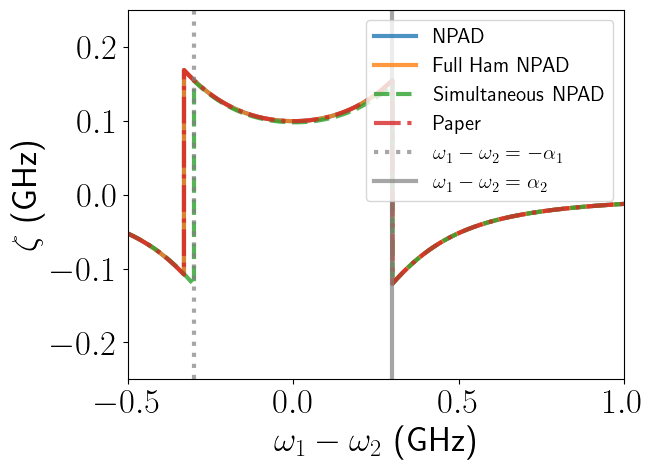

In [77]:
npad_zz = sympy.lambdify(
    omega12,
    expr=(
        (delta + M2[1, 1])
        .subs([(g1, sympy.sqrt(2) * g), (g2, sympy.sqrt(2) * g)])
        .subs([delta_defn, Delta_defn])
        .subs([(alpha1, -0.3), (alpha2, -0.3), (g, 0.1)])
    ),
)

chain_npad_zz = sympy.lambdify(
    omega12,
    expr=(
        chain_full_zz.subs(
            [
                (a1, -0.3),
                (a2, -0.3),
                (gf, 0.1),
                (w2, w1 - omega12),
                (w1, 5),
            ]
        ),
    ),
    modules=["scipy", "numpy"],
)

sim_npad_zz = sympy.lambdify(
    omega12,
    expr=(
        (delta + M2sim[1, 1])
        .subs([(g1, sympy.sqrt(2) * g), (g2, sympy.sqrt(2) * g)])
        .subs([delta_defn, Delta_defn])
        .subs([(alpha1, -0.3), (alpha2, -0.3), (g, 0.1)])
    ),
)
paper_npad_zz = sympy.lambdify(
    omega12,
    expr=(
        (paper_zz)
        .subs(c01sym, c01)
        .subs(E2sym, E2)
        .subs([(g1, sympy.sqrt(2) * g), (g2, sympy.sqrt(2) * g)])
        .subs([delta_defn, Delta_defn])
        .subs([(alpha1, -0.3), (alpha2, -0.3), (g, 0.1)])
    ),
)

detuning_list = np.linspace(-0.5, 1, 10000)

npad_zz_list = npad_zz(detuning_list)
chain_npad_zz_list = chain_npad_zz(detuning_list)[0]
sim_npad_zz_list = sim_npad_zz(detuning_list)
paper_npad_zz_list = paper_npad_zz(detuning_list)
fig, ax = plt.subplots()
ax.plot(detuning_list, npad_zz_list, label="NPAD", alpha=0.8, ls="-", lw=3)
ax.plot(
    detuning_list, chain_npad_zz_list, label="Full Ham NPAD", alpha=0.8, ls="-", lw=3
)
ax.plot(
    detuning_list, sim_npad_zz_list, label="Simultaneous NPAD", alpha=0.8, ls="--", lw=3
)
ax.plot(detuning_list, paper_npad_zz_list, label="Paper", alpha=0.8, ls="-.", lw=3)
ax.set(
    ylabel=r"$\zeta$ (GHz)",
    xlabel=r"$\omega_1 - \omega_2$ (GHz)",
    xlim=(-0.5, 1),
    ylim=(-1, 1),
)
ax.axvline(
    x=-0.3,
    alpha=0.7,
    c="gray",
    ls=":",
    label=r"$\omega_1 - \omega_2 = -\alpha_1$",
)
ax.axvline(
    x=0.3,
    alpha=0.7,
    c="gray",
    label=r"$\omega_1 - \omega_2 = \alpha_2$",
)
ax.set(ylim=(-0.25, 0.25))
ax.legend(fontsize=15)

The takeaway from this is that while simulatneous NPAD does indeed recover all the qualitative features of this behavior, ~~iterative NPAD performs more accurately because simultaneous NPAD (while eventually converging to the correct diagonal matrix) doesn't account for these corrections with only one or a few rotations. Since both rotations share some common levels, doing this simultaneously is a bad idea.~~ **Need to examine this more closely.** Is simultaneous NPAD better?